# Fine-tuning on 120 breeds

I will be fine-tuning the best model from previous notebook. 
* Data augmenation
* Inception V3 model
* Adam Optimizer
* Categorical crossentropy loss
* Global Average Pooling 2D
* Unfreeze all base layers
* Small learning rate alpha = 10-5


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Dropout
from tensorflow import keras
import cv2
from glob import glob

from keras.models import model_from_json

# Adam - InceptionV3

## Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 16468 images belonging to 120 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2015 images belonging to 120 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 2159 images belonging to 120 classes.


In [ ]:
# list(training_set.class_indices.keys())

## model

In [ ]:
base_model = keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

UnFreeze the base model

In [ ]:
base_model.trainable = True

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
# A Dense classifier
outputs = keras.layers.Dense(120, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               15480     
Total params: 22,080,536
Trainable params: 22,046,104
Non-trainable params: 34,432
__________________________________________

Train the model on new data

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks

checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 15,
                                        restore_best_weights = True
                                        )

model_fit = model.fit(training_set, epochs=100,
                      callbacks=[earlystopping, model_checkpoint_callback],
                      validation_data=validation_set)

Epoch 1/100
515/515 [==============================] - 6345s 12s/step - loss: 4.3791 - accuracy: 0.0781 - val_loss: 1.4287 - val_accuracy: 0.7042
Epoch 2/100
515/515 [==============================] - 435s 845ms/step - loss: 2.1773 - accuracy: 0.4822 - val_loss: 0.9073 - val_accuracy: 0.7811
Epoch 3/100
515/515 [==============================] - 438s 850ms/step - loss: 1.5788 - accuracy: 0.6135 - val_loss: 0.7773 - val_accuracy: 0.8020
Epoch 4/100
515/515 [==============================] - 442s 857ms/step - loss: 1.3337 - accuracy: 0.6687 - val_loss: 0.6898 - val_accuracy: 0.8179
Epoch 5/100
515/515 [==============================] - 436s 846ms/step - loss: 1.2055 - accuracy: 0.7012 - val_loss: 0.6448 - val_accuracy: 0.8253
Epoch 6/100
515/515 [==============================] - 436s 846ms/step - loss: 1.0632 - accuracy: 0.7336 - val_loss: 0.6167 - val_accuracy: 0.8308
Epoch 7/100
515/515 [==============================] - 436s 847ms/step - loss: 0.9408 - accuracy: 0.7587 - val_loss: 0.

## evaluation

Accuracy vs Epochs

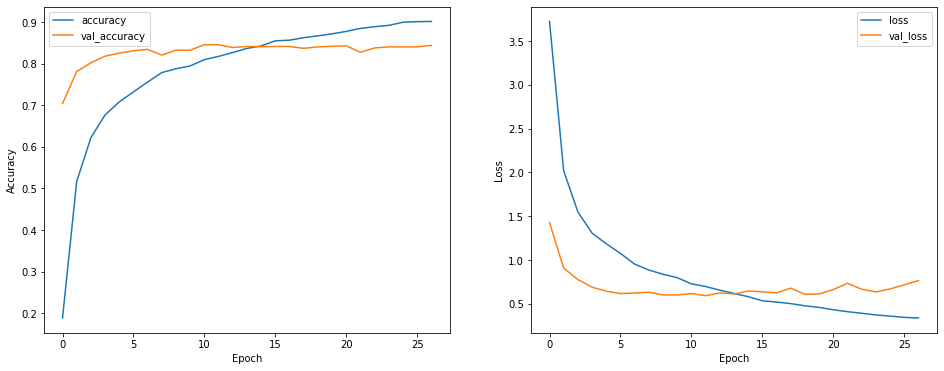

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
prediction = model.evaluate(test_set)
prediction

68/68 [==============================] - 785s 12s/step - loss: 0.6361 - accuracy: 0.8342


[0.6361448764801025, 0.8341825008392334]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))

In [ ]:
predicted_classes = np.array(l)
predicted_classes.shape

(2159,)

In [ ]:
test_set.classes.shape

(2159,)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_score(predicted_classes, test_set.classes)

0.8341824918943955

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.92      0.92      0.92        25\n           1       1.00      1.00      1.00        18\n           2       0.95      0.95      0.95        21\n           3       0.65      0.55      0.59        20\n           4       0.62      0.91      0.74        11\n           5       0.90      0.73      0.81        26\n           6       1.00      0.95      0.97        20\n           7       0.96      0.85      0.90        26\n           8       0.85      0.89      0.87        19\n           9       0.80      0.60      0.69        20\n          10       1.00      0.82      0.90        22\n          11       1.00      0.95      0.97        20\n          12       0.80      0.92      0.86        13\n          13       0.88      0.88      0.88        16\n          14       0.56      1.00      0.72         9\n          15       0.62      1.00      0.77        10\n          16       0.89      0.76      0.82        21\n       

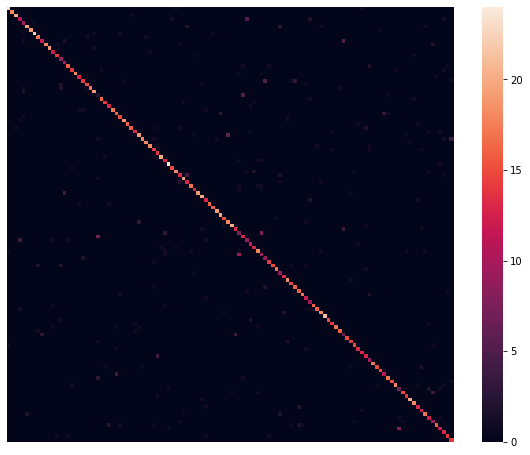

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
plt.axis('off')
confusion = confusion_matrix(predicted_classes, test_set.classes)
sns.heatmap(confusion)

## save model

In [ ]:
# # serialize model to JSON
# inceptionV3_120_breeds_best_json = model.to_json()
# with open("inceptionV3_120_breeds_best.json", "w") as json_file:
#     json_file.write(inceptionV3_120_breeds_best_json)
# # serialize weights to HDF5
# model.save_weights("inceptionV3_120_breeds_best.h5")
# print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('inceptionV3_120_breeds_best.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("inceptionV3_120_breeds_best.h5")
print("Loaded model from disk")

Loaded model from disk


## classification report

In [ ]:
loaded_model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
prediction = loaded_model.evaluate(test_set)
prediction

In [ ]:
predicted_probabilities = loaded_model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))

In [ ]:
predicted_classes = np.array(l)
predicted_classes.shape

(2159,)

In [ ]:
test_set.classes.shape

(2159,)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_score(predicted_classes, test_set.classes)

0.8341824918943955

In [ ]:
report = classification_report(predicted_classes, test_set.classes, output_dict=True)

In [ ]:
df = pd.DataFrame(report).transpose()

In [ ]:
df

,precision,recall,f1-score,support
0,0.920000,0.920000,0.920000,25.000000
1,1.000000,1.000000,1.000000,18.000000
2,0.952381,0.952381,0.952381,21.000000
3,0.647059,0.550000,0.594595,20.000000
4,0.625000,0.909091,0.740741,11.000000
...,...,...,...,...
118,0.875000,0.777778,0.823529,18.000000
119,0.700000,1.000000,0.823529,14.000000
accuracy,0.834182,0.834182,0.834182,0.834182
macro avg,0.832466,0.840796,0.829772,2159.000000


In [ ]:
df_120 = df.iloc[:120]

In [ ]:
df_120['breeds'] = test_set.class_indices.keys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_120

,precision,recall,f1-score,support,breeds
0,0.920000,0.920000,0.920000,25.0,Afghan_hound
1,1.000000,1.000000,1.000000,18.0,African_hunting_dog
2,0.952381,0.952381,0.952381,21.0,Airedale
3,0.647059,0.550000,0.594595,20.0,American_Staffordshire_terrier
4,0.625000,0.909091,0.740741,11.0,Appenzeller
...,...,...,...,...,...
115,0.941176,0.666667,0.780488,24.0,tan_coonhound
116,0.750000,0.571429,0.648649,21.0,toy_poodle
117,0.722222,1.000000,0.838710,13.0,toy_terrier
118,0.875000,0.777778,0.823529,18.0,vizsla


In [ ]:
df_120.describe()

,precision,recall,f1-score,support
count,120.000000,120.000000,120.000000,120.000000
mean,0.832466,0.840796,0.829772,17.991667
std,0.156998,0.138482,0.131597,4.042829
min,0.133333,0.250000,0.173913,8.000000
25%,0.750000,0.776515,0.778914,15.000000
50%,0.875000,0.870833,0.857143,18.000000
75%,0.944444,0.937500,0.919189,21.000000
max,1.000000,1.000000,1.000000,28.000000


In [ ]:
df_120.sort_values(by='f1-score')[:10]

,precision,recall,f1-score,support,breeds
24,0.133333,0.250000,0.173913,8.0,Eskimo_dog
62,0.363636,0.421053,0.390244,19.0,Shih_Tzu
68,0.409091,0.473684,0.439024,19.0,Tzu
90,0.437500,0.500000,0.466667,14.0,collie
105,0.437500,0.636364,0.518519,11.0,miniature_poodle
64,0.562500,0.562500,0.562500,16.0,Staffordshire_bullterrier
3,0.647059,0.550000,0.594595,20.0,American_Staffordshire_terrier
114,0.562500,0.750000,0.642857,12.0,standard_schnauzer
116,0.750000,0.571429,0.648649,21.0,toy_poodle
63,0.650000,0.650000,0.650000,20.0,Siberian_husky


In [ ]:
test_set.classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [ ]:
predicted_classes

array([  0,   0,   0, ...,  36, 119, 119])

In [ ]:
true_predicted = pd.DataFrame([test_set.classes, predicted_classes]).transpose().

In [ ]:
true_predicted = true_predicted.rename({0:'true', 1:'predicetd'}, axis=1)

In [ ]:
true_predicted[true_predicted['true']==24].value_counts()

true  predicetd
24    63           7
      102          3
      24           2
      92           1
      47           1
      36           1
dtype: int64

7/15 eskimo_dog images were wrongly classified as siberian_husky

In [ ]:
true_predicted[true_predicted['true']==62].value_counts()

true  predicetd
62    68           9
      62           8
      67           1
      50           1
      49           1
      42           1
      18           1
dtype: int64

8/22 shi_tzu images were wrongly classified as tzu




In [ ]:
true_predicted[true_predicted['true']==90].value_counts()

true  predicetd
90    90           7
      9            5
      61           4
dtype: int64

5/16 collie images were wrongly classified as border_collie

In [ ]:
test_set.class_indices

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'Gordon_setter': 27,
 'Great_Dane': 28,
 'Great_Pyrenees': 29,
 'Greater_Swiss_Mountain_dog': 30,
 'Ibizan_hound': 31,
 'Irish_setter': 32,
 'Irish_terrier': 33,
 'Irish_water_spaniel': 34,
 'Irish_wolfhound': 35,
 'Italian_greyhound': 36,
 'Japanese_spaniel': 37,
 'Kerry_blue_terrier': 38,
 'Labrador_retriever': 39,
 'Lakeland_terrier': 40,
 'Leonberg': 41,
 'L